In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import plotly
import plotly.express as px

pd.options.mode.chained_assignment = None  # default='warn'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd. options. plotting. backend = "plotly"

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('precision',4)

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Term structure data

In [2]:
# TNC (Treasury Nominal Coupon) month-end spot rate files are provided as 5-year chunks of data
# First column is 'Maturity', with rows at 0.5 year intervals, upto 100 years.
# Other columns are for each month-end for 5 years.

def ProcessInput(df,start,end):
    l=[]
    for year in range(start,end+1):
        l = l+12*[str(year)]
    NewNames = df.columns[1:].str.slice(stop=3)+pd.Series(l)
    NewNames = (pd.Series('Maturity').append(NewNames)).reset_index(drop=True)
    df = df.rename(columns=dict(zip(df.columns.values,NewNames)))
    df = df.melt(id_vars='Maturity',var_name='Date',value_name='SpotRate')
    df["Date"] = (pd.to_datetime(df["Date"],format="%b%Y")).dt.date+pd.offsets.MonthEnd(0)
    df["SpotRate"] = df["SpotRate"]/100
    return(df)

# Read in each file and process it. End result is a composite long form dataframe

suffixes = ['03_07','08_12','13_17','18_22']
dflist=[]
for x in suffixes:
    file = "tnceom_"+x+".csv"
    filedf = pd.read_csv(file,skiprows=4)
    filedf = filedf.drop(columns=filedf.columns[1],index=filedf.index[0])   # blank column and row
    start = int('20'+x[0:2])
    end = int('20'+x[3:])
    dflist.append(ProcessInput(filedf,start,end))

tncdf = pd.concat(dflist).reset_index(drop=True).dropna(subset=["SpotRate"])

In [3]:
TSPoints = np.array([0.5,1.0,2.0,3.0,5.0,10.0,20.0,30.0])
TSdf = tncdf.loc[tncdf["Maturity"].isin(TSPoints),:]

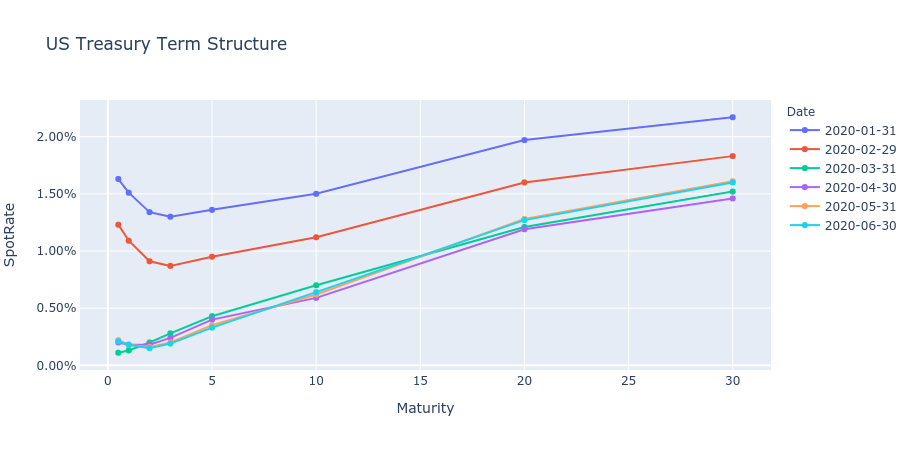

In [4]:
TSDates = ['20200131','20200229','20200331','20200430','20200531','20200630']
plotDF = TSdf.loc[TSdf["Date"].isin(TSDates),:].reset_index(drop=True)
plotDF["Date"] = plotDF["Date"].dt.date.astype(str)

px.line(plotDF,x="Maturity",y="SpotRate",color="Date",title="US Treasury Term Structure")\
.update_layout(yaxis=dict(tickformat=".2%")).update_traces(mode='lines+markers')

# PCA

## Background

Let $\mathbf{X}$ be an $n\times k$ matrix whose columns are centered - i.e., the mean of each column is zero. Then the $k\times k$ covariance matrix $\mathbf{\Sigma}$ is

\begin{equation}
\mathbf{\Sigma} = \frac{1}{n}\mathbf{X'X}
\end{equation}

We can diagonalize the covariance matrix by the similarity transformation

\begin{equation}
\mathbf{\Sigma} = \mathbf{U\Lambda U'}
\end{equation}
where
* $\mathbf{U}$ is a $k\times k$ matrix whose columns are eigenvectors of $\mathbf{\Sigma}$
* $\mathbf{U}$ is an orthogonal matrix, $\mathbf{UU'= U'U = I}$
* $\mathbf{\Lambda}$ is a diagonal matrix consisting of the eigenvalues of $\mathbf{\Sigma}$

In addition:

* If $\mathbf{\Sigma}$ is real and symmetric, its eigenvalues are real
* If the eigenvalues $\lambda_i > 0 \; \forall\, i$, then $\mathbf{\Sigma}$ is positive definite
* If some $\lambda_i = 0$, then $\mathbf{\Sigma}$ is positive semi-definite if the *non-zero* $\lambda_i$ are greater than zero

**Variation and reduction in dimensionality**

$$
\text{Total variation} = \sum_i \sigma_i^2 = tr(\mathbf{\Sigma}) = tr(\mathbf{\Lambda}) = \sum_i \lambda_i
$$
where $tr(.)$ is the trace of a matrix and we have used the fact that $tr(\mathbf{\Sigma})=tr(\mathbf{U\Lambda U'})=tr(\mathbf{U'U\Lambda})=tr(\mathbf{\Lambda})$.

The vectors in $\mathbf{X}$ can be transformed to a new basis by post-multiplying them with the matrix $\mathbf{U}$:

\begin{equation}
\mathbf{P} = \mathbf{X U}
\end{equation}

The columns of $\mathbf{P}$ are known as principal components. These components are orthogonal to each other. The $j$th principal component is 

\begin{equation}
\mathbf{P}_j = \mathbf{X}\mathbf{U}_j
\end{equation}
where $\mathbf{U}_j$ is the $j$th column of $\mathbf{U}$.

The proportion of total variation explained by the $j$th principal component is $\frac{\lambda_i}{\sum_i \lambda_i}$. Often, a few principal components can account for a large fraction of the variation. Thus we may choose to ignore the eigenvectors corresponding to the smaller eigenvalues. This is what leads to **dimensionality reduction**.

The matrix $\mathbf{X}$ can be recovered by noting that $\mathbf{X}=\mathbf{PU'}$.

**Relationship to Singular Value Decomposition (SVD)**

Singular value decomposition is a non-unique decomposition of the matrix $\mathbf{X}$ such that

$$
\mathbf{X}_{n\times k} = \mathbf{V}_{n\times n} \mathbf{S}_{n\times k} \mathbf{U'}_{k\times n}
$$

and 
* $\mathbf{V, U}$ are unitary (orthogonal if $\mathbf{X}$ is real)
* $\mathbf{S}$ is diagonal

From this, we see that

$$
\mathbf{\Sigma} = \frac{1}{n}\mathbf{X'X} = \frac{1}{n} \mathbf{U\,S\,V'\,V\,S\,U'} = \frac{1}{n} \mathbf{U\, S^2\, U'}
$$

which means that $\frac{1}{n} \mathbf{S^2} = \mathbf{\Lambda}$. Since $\mathbf{S}$ is diagonal, it follows that

$$
\frac{1}{n} s_i^2 = \lambda_i
$$

## Implementation

In [5]:
from sklearn.decomposition import PCA
np.set_printoptions(precision=3, suppress=True)

In [6]:
test = plotDF.pivot(index='Date',columns='Maturity',values='SpotRate')
Xdf = test.diff().dropna()
X = Xdf.values

In [7]:
#PCA code.  Steps
# 1. Center X
# 2. Compute Sigma = (1/n) X'X
# 3. Compute eigenvalues and eigenvectors. 
# 4. Order eigenvalues by magnitude. Choose eigenvectors corresponding to a few of the largest eigenvalues.

def myPCA(X):
    X = X - np.mean(X,axis=0)
    Sigma = np.cov(X,rowvar=False)

    e,U = np.linalg.eigh(Sigma)    # eigenvalues and eigenvectors

    OrderEV = np.argsort(e)[::-1]  # indices of eigenvalues sorted by magnitude. '[::-1]' reverses the vector.
    l = e[OrderEV]
    U = U[:,OrderEV]               # columns of U have to be ordered according to order of eigenvalues
    PC = X @ U
    return ((l,U,PC))

In [8]:
l,U,PC = myPCA(X)
(100*l)/sum(l)
U
PC

array([95.059,  4.362,  0.444,  0.135,  0.   ,  0.   , -0.   , -0.   ])

array([[-0.564,  0.499,  0.34 , -0.023, -0.112,  0.341,  0.042,  0.432],
       [-0.488,  0.273,  0.022, -0.047,  0.479, -0.319, -0.006, -0.594],
       [-0.362, -0.046, -0.217, -0.041, -0.675, -0.497, -0.339, -0.003],
       [-0.303, -0.17 , -0.434,  0.055, -0.228,  0.22 ,  0.75 , -0.159],
       [-0.267, -0.186, -0.503,  0.35 ,  0.23 ,  0.443, -0.518,  0.041],
       [-0.228, -0.4  , -0.096, -0.806,  0.247,  0.009, -0.052,  0.258],
       [-0.238, -0.408,  0.18 ,  0.466,  0.295, -0.444,  0.197,  0.452],
       [-0.203, -0.534,  0.595,  0.066, -0.221,  0.306, -0.105, -0.402]])

array([[ 0.005,  0.003,  0.   , -0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [ 0.013, -0.002, -0.   ,  0.   ,  0.   , -0.   , -0.   , -0.   ],
       [-0.006,  0.001, -0.   ,  0.   ,  0.   , -0.   ,  0.   , -0.   ],
       [-0.006, -0.002,  0.001, -0.   , -0.   ,  0.   , -0.   ,  0.   ],
       [-0.006, -0.001, -0.001, -0.   , -0.   ,  0.   ,  0.   ,  0.   ]])

In [9]:
# Comparison with scikit-learn PCA

pca = PCA()          # Creating an object
fit = pca.fit(X)
print(100*fit.explained_variance_ratio_)
print(fit.components_)                           # This is U'
pca.fit_transform(X)

[95.059  4.362  0.444  0.135  0.   ]
[[-0.564 -0.488 -0.362 -0.303 -0.267 -0.228 -0.238 -0.203]
 [ 0.499  0.273 -0.046 -0.17  -0.186 -0.4   -0.408 -0.534]
 [ 0.34   0.022 -0.217 -0.434 -0.503 -0.096  0.18   0.595]
 [-0.023 -0.047 -0.041  0.055  0.35  -0.806  0.466  0.066]
 [ 0.258 -0.602  0.447  0.372 -0.437 -0.087  0.143 -0.116]]


array([[ 0.005,  0.003,  0.   , -0.   ,  0.   ],
       [ 0.013, -0.002, -0.   ,  0.   ,  0.   ],
       [-0.006,  0.001, -0.   ,  0.   ,  0.   ],
       [-0.006, -0.002,  0.001, -0.   ,  0.   ],
       [-0.006, -0.001, -0.001, -0.   ,  0.   ]])

# PCA factors for US Treasury spot rate changes

In [10]:
TSXdf = TSdf.pivot(index='Date',columns='Maturity',values='SpotRate').diff().dropna()
TSX = TSXdf.values

In [25]:
# Running PCA on the entire panel

X = TSXdf.values
dvec = TSXdf.index

pca = PCA()          # Creating an object
fit = pca.fit(X)

evr = np.cumsum(fit.explained_variance_ratio_)
PC = pd.DataFrame(pca.fit_transform(X), columns=['PC'+str(x) for x in range(pca.n_components_)])
PC = pd.concat([pd.Series(dvec),PC],axis=1)

print(evr)
#PC

[0.769 0.934 0.978 0.995 0.998 1.    1.    1.   ]


In [27]:
# Save a 4 component factor model
PC.iloc[:,0:5].to_pickle("s3://multifactor-etf/UST_PC4.pkl")